Importing dependancies

In [466]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from random import seed
from random import random
seed(1)

Get our data and get a preview

In [467]:
bankruptcy_df = pd.read_csv(r'bankruptcy.csv',header = 0)
bankruptcy_df.head()

,Firm,SALES,ROCE,FFTL,GEAR,CLTA,CACL,QACL,WCTA,LAG,AGE,CHAUD,BIG6,FAIL
0,o1,6762,7.5364,0.1545,0.6233,0.6233,1.5489,0.7356,0.3422,96,74,0,0,0
1,o2,16149,-1.0712,0.0271,1.2218,1.2218,0.6236,0.3153,-0.4599,287,29,0,1,0
2,o3,8086,15.2024,0.6163,0.3307,0.3307,2.3553,1.7513,0.4482,64,51,0,1,0
3,o4,7646,31.2239,0.6312,0.5205,0.4829,1.6397,1.4935,0.3089,286,25,0,0,0
4,o5,36067,10.9613,0.3540,0.3786,0.3786,1.5852,1.1626,0.2216,301,33,0,1,0


Looking at a description of the data

In [468]:
bankruptcy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Firm    60 non-null     object 
 1   SALES   60 non-null     int64  
 2   ROCE    60 non-null     float64
 3   FFTL    60 non-null     float64
 4   GEAR    60 non-null     float64
 5   CLTA    60 non-null     float64
 6   CACL    60 non-null     float64
 7   QACL    60 non-null     float64
 8   WCTA    60 non-null     float64
 9   LAG     60 non-null     int64  
 10  AGE     60 non-null     int64  
 11  CHAUD   60 non-null     int64  
 12  BIG6    60 non-null     int64  
 13  FAIL    60 non-null     int64  
dtypes: float64(7), int64(6), object(1)
memory usage: 6.7+ KB


Balanced class distribution is so we don't need to resample

In [469]:
bankruptcy_df.groupby(['FAIL'])[['FAIL']].count()

,FAIL
FAIL,
0,30
1,30


Summary of attributes

In [470]:
bankruptcy_df.describe()

,SALES,ROCE,FFTL,GEAR,CLTA,CACL,QACL,WCTA,LAG,AGE,CHAUD,BIG6,FAIL
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,15340.733333,0.892990,0.134183,0.783590,0.615423,1.222795,0.858393,0.040293,241.383333,26.283333,0.216667,0.516667,0.500000
std,20299.682971,13.077896,0.185466,0.434347,0.257975,0.593600,0.492965,0.232599,83.301798,21.886527,0.415450,0.503939,0.504219
min,2857.000000,-37.350000,-0.328300,0.121200,0.121200,0.497400,0.284700,-0.747000,55.000000,2.000000,0.000000,0.000000,0.000000
25%,4016.250000,-5.593675,0.026550,0.592350,0.448650,0.836475,0.517975,-0.099975,182.000000,10.750000,0.000000,0.000000,0.000000
50%,7299.500000,0.788550,0.102100,0.742800,0.621550,1.153000,0.731950,0.083700,266.500000,23.000000,0.000000,1.000000,0.500000
75%,16876.500000,7.653850,0.215725,0.864975,0.741825,1.400725,1.162950,0.208125,301.000000,33.000000,0.000000,1.000000,1.000000
max,103541.000000,33.845100,0.631200,3.533600,1.486500,4.446500,3.363500,0.448200,421.000000,90.000000,1.000000,1.000000,1.000000


Data Preparation. We split into train and test datasets, with 80% going to training and 20% going to testing

In [471]:
from sklearn.model_selection import train_test_split
X = bankruptcy_df[bankruptcy_df.columns.difference(['Firm', 'FAIL'])]
y = bankruptcy_df[['FAIL']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Remove mean and scale to unit variance z=(x-u)/s of both train and test

In [472]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Finally, we finish our data preparation by selecting only the K (in our case k=12) best features.

In [473]:
from sklearn.feature_selection import SelectKBest
k = 12
prep = SelectKBest(k=k)
X_train = prep.fit_transform(X_train, y_train.values.flatten())
X_test = prep.fit_transform(X_test, y_test.values.flatten())

Building necessary functions

This function takes the training data, the parameters 𝜃, and the regularization parameter lambda,
then computes and returns the regularized cost function:

Sigmoid Function where

$h_\theta(x) = \frac{1}{1 + exp(-z)} $

and

$z = \theta^T x $

In [474]:
def sigmoid(z):
  # return 1/(1 + exp(-z))
  return 1 / ( 1 + np.exp(-z))

Cost function where

$J(\theta) = \frac{1}{m} [\sum_{i=1}^m(-y^{(i)}logh_\theta(x^{(i)}) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))) + \frac{\lambda}{2}\sum_{j=1}^n\theta_j^2]$

In [475]:
def cost(X, y, theta, lambdad):
 # Write your code here
 m, n = X.shape
 h_theta = sigmoid(np.dot(X, theta)) # h_𝜃 (x) = sigmoid (x^T * 𝜃)

 # for each ith get cost and sum

 m_sum = -np.sum((y*np.log(h_theta)) + (1 - y)*np.log(1 - h_theta))
 n_sum = np.sum(theta**2)  # sum from 1 -> n of 𝜃𝑗^2
 total = m_sum + (lambdad/2) * n_sum # everything in brackets
 result = total / m

 return result  # return the cost in cst


Optimize function. We run gradient descent to compute optimal $\theta$

In [476]:
def optimize(X ,y, lambdad, maxrun, alpha):
  m, n = X.shape
  X = np.hstack((X, np.ones((m, 1))))
  theta = np.random.rand(n + 1, 1)
  costs = []

  for iter in range(0, maxrun):
    # Write your code here
    costs.append(cost(X, y, theta, lambdad))
    h_theta = sigmoid(np.dot(X, theta))
    gradient = np.dot(X.T, h_theta - y) / m
    gradient[1:] += (lambdad/m) * theta[1:] # for nonzero terms add lambda/m*theta_j
    theta = theta - alpha*gradient # iterate to next theta by subtracting alpha (or step) * gradient


  return theta, costs

Predict function. Takes in test data and the optimal $\theta$ and returns predicted class labels for test examples in test dataset

In [477]:
def predict(X, theta):
  # Write your code here
  m, n = X.shape
  X = np.hstack((X, np.ones((m, 1))))
  result = sigmoid(np.dot(X, theta))
  return result

In the following, adjust lambdad to adjust regularization to overcome overfitting by trying. The assignment doesn't require to do cross validation.



In [478]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler

lambdad = 10
maxrun = 2000 # number of epochs
step = 0.01
scaler = MaxAbsScaler()
X_train_ = scaler.fit_transform(X_train, y_train)
X_test_ = scaler.transform(X_test)

optimal_theta, costs = optimize(X_train_, y_train.values, lambdad, maxrun, step)

threshold = 0.5 # adjustable
y_test_pred = predict(X_test_, optimal_theta) > threshold
print("Accuracy:",accuracy_score(y_test, y_test_pred))
y_train_pred = predict(X_train_, optimal_theta) > threshold
print("Accuracy:",accuracy_score(y_train, y_train_pred))

Accuracy: 0.8333333333333334
Accuracy: 0.75


0.6419637237629042
Accuracy: 0.8333333333333334
[[5 2]
 [0 5]]


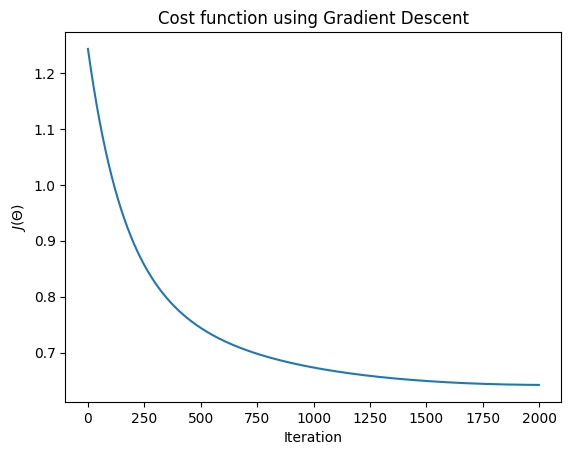

In [479]:
print(costs[-1])
plt.plot(costs)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
y_test_pred = predict(X_test_, optimal_theta) > 0.5
print("Accuracy:",accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))